# Transcriptome assembly and assessment
This notebook includes the analyses performed in order to assemble transcriptome data from multiple tomato accessions towards transcript-based genome annotation.  
The analysis starts by exploring the official ITAG _S. lycopersicum_ annotation in order to set a baseline for quality metrics.  
Then, a pan-transcriptome-assembly procedure per _Solanum_ species is performed. This analysis includes the following general steps (although see detailed description below):
1. Download RNA-seq data from multiple studies (hosted on SRA), covering diverse variants, tissues and conditions.
2. Assemble each data set independently, using Trinity with its genome-guided mode.
3. QA each result and filter unreliable outputs.
4. Perform transcriptome-merging from all data sets, using StringTie (merge mode) to obtain a single non-redundant species-specific pan-transcriptome.
5. Further QA and cleanup on merged transcriptome.

In [1]:
import sys
sys.path.append('../../queue_utilities/')
from queueUtils import *
queue_conf = '../../queue_utilities/queue.conf'
sys.path.append('../python/')
from os.path import realpath
from os import chdir
import os
from get_genome_stats import get_stats
import pandas
from IPython.display import display
pandas.set_option('display.float_format', lambda x: "{:,.2f}".format(x) if int(x) != x else "{:,.0f}".format(x))
from shutil import rmtree
from subprocess import Popen

DATA_PATH = realpath("../data/")
PY_PATH = realpath("../python/")
FIGS_PATH = realpath("../figs/")
OUT_PATH = realpath("../output/")

busco_dir = "/groups/itay_mayrose/liorglic/software/busco"
%matplotlib inline
import matplotlib.pyplot as plt

## Reference transcriptome assessment
The first stage of this analysis is to get some statistics on the official tomato reference transcriptome.  
This should serve as a baseline for later QA of newly-assembled transcriptomes from non-reference accessions.  
QA procedures outlined in the [trinity tutorial](https://github.com/trinityrnaseq/trinityrnaseq/wiki/Transcriptome-Assembly-Quality-Assessment) were followed.

### Get data
Data from the Heinz 1706 reference assembly SL3.0 annotation build ITAG3.2

In [7]:
itag32_ftp_url = "ftp://ftp.solgenomics.net/tomato_genome/annotation/ITAG3.2_release/ITAG3.2_cDNA.fasta"
download_command = "wget %s -P %s" % (itag32_ftp_url, realpath(DATA_PATH))
send_commands_to_queue('download_itag32_cdna', download_command, queue_conf)

Job download_itag32_cdna (job id 1277211) completed successfully


('1277211', '0')

In [6]:
itag32_cdna_fasta_path = "%s/ITAG3.2_cDNA.fasta" % DATA_PATH

### Basic stats

In [33]:
itag32_stats = get_stats(itag32_cdna_fasta_path)

In [35]:
display(pandas.DataFrame.from_dict(itag32_stats, orient='index'))

,0
Total length,"54,440,050"
Total scaffolds,"35,768"
# of gaps,"241,894"
% gaps,0.44
N50,"2,226"
L50,"7,838"
N90,801
L90,"22,989"
Min scaffold length,63
Max scaffold length,"23,222"


### Run BUSCO
Run BUSCO to assess completeness of transcripts set.

In [31]:
busco_command = "python %s/scripts/run_BUSCO.py --in %s --out ITAG3.2_BUSCO --lineage_path %s/embryophyta_odb9/ --mode transcriptome" \
% (busco_dir, realpath(itag32_cdna_fasta_path), busco_dir)
env_commands = ['export PATH="/share/apps/augustus/bin:$PATH"',
               'export PATH="/share/apps/augustus/scripts:$PATH"',
               'export AUGUSTUS_CONFIG_PATH="/groups/itay_mayrose/liorglic/software/busco/augustus_config"',
               "cd %s" % realpath(OUT_PATH)]
busco_run_commands = env_commands + [busco_command]
send_commands_to_queue("ITAG32_BUSCO", busco_run_commands, queue_conf, block=False, n_cpu=20)

('1281124', None)

### Full length transcripts
In this analysis, transcripts are aligned to all known proteins from SwissProt in order to determine the distribution of % coverage of protein sequences by transcripts. See further explanation [here](https://github.com/trinityrnaseq/trinityrnaseq/wiki/Counting-Full-Length-Trinity-Transcripts).

In [3]:
# download and extract SwissProt
sp_ftp_url = "ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
download_command = "wget %s -P %s" %(sp_ftp_url, realpath(DATA_PATH))
extract_command = "gzip -d %s/uniprot_sprot.fasta.gz" % realpath(DATA_PATH)
send_commands_to_queue("get_SwissProt",[download_command, extract_command],queue_conf)

In [7]:
# build blast DB
sp_fasta = "%s/uniprot_sprot.fasta" % DATA_PATH

In [ ]:
build_blast_db_commands = ['module load blast/blast240',
                          'makeblastdb -in %s -dbtype prot' % realpath(sp_fasta)]
send_commands_to_queue("build_SP_blast_DB",build_blast_db_commands,queue_conf, block=False)

In [8]:
# Perform the blast search, reporting only the top alignment:
blast_res = OUT_PATH + "ITAG_vs_SP.blastx.outfmt6"
blast_search_commands = ['module load blast/blast240',
                        'blastx -query %s -db %s -out %s -evalue 1e-20 -num_threads 10 -max_target_seqs 1 -outfmt 6'
                         %(realpath(itag32_cdna_fasta_path), realpath(sp_fasta), realpath(blast_res))]
send_commands_to_queue("blast_ITAG_vs_SP",blast_search_commands,queue_conf, block=False, n_cpu=10)

In [10]:
# use utility script provided within Trinity to parse blast result
script_path = "/share/apps/Trinity-v2.6.6/util/analyze_blastPlus_topHit_coverage.pl"
parse_blast_res_commands = ["%s %s %s %s"
                            %(script_path, realpath(blast_res), realpath(itag32_cdna_fasta_path), realpath(sp_fasta))]
send_commands_to_queue('parse_ITAG_blast_res', parse_blast_res_commands, queue_conf)

Job parse_ITAG_blast_res (job id 1508779) completed successfully


('1508779', '0')

In [13]:
full_length_hist = OUT_PATH + "ITAG_vs_SP.blastx.outfmt6.hist"
display(pandas.DataFrame.from_csv(full_length_hist, sep='\t'))

,count_in_bin,>bin_below
#hit_pct_cov_bin,,
100,6751,6751
90,1538,8289
80,759,9048
70,534,9582
60,447,10029
50,418,10447
40,318,10765
30,260,11025
20,218,11243


## _S. lycopersicum_ pan transcriptome

The table below describes the data sets used in the analysis. Each data set corresponds to a single variant from a single study. Multiple tissues, conditions, developmental stages and library types may be included. A data set ID is composed of the study ID (s) and the variant ID (v).

In [3]:
s_lyc_datasets_tsv = DATA_PATH + "/S_lyc_RNA_seq_datasets.tsv"
s_lyc_datasets = pandas.read_csv(s_lyc_datasets_tsv, sep='\t')
s_lyc_datasets.index.name = 'ID'
s_lyc_datasets

,Code,Variant,SRR list,Gb data
ID,,,,
0,s1v1,Micro-Tom,DRR074670 DRR074671 DRR074672 DRR074673,9.50
1,s2v1,Moneymaker,ERR1533151 ERR1533152 ERR1533153 ERR1533156 ER...,26
2,s4v1,PI114490,SRR390335 SRR390336,2.58
3,s4v2,FL7600,SRR389806 SRR389807,2.70
4,s4v3,NC84173,SRR389808 SRR390315,2.64
5,s4v4,OH9242,SRR390328 SRR390329,2.58
6,s4v5,T5,SRR390330 SRR390331,2.91
7,s5v1,M82,SRR863016 SRR863017 SRR863018 SRR863024 SRR863025,1.54
8,s6v1,Ailsa Craig,SRR863042 SRR863043 SRR863044 SRR863045 SRR863...,20.08


Each data set was processed using the following steps:
1. Download raw RNA-seq data using sra toolkit fastq-dump
1. Parse downloaded file names to detect paired end libraries and prepare for assembly
1. Align reads to reference genome using STAR and sort bam file using samtools. This step also generates a fastq of unmapped (and disconcordant) reads.
1. Use alignment results and raw data for genome-guided assembly using Trinity.
1. Use unmapped reads for de-novo assembly using Trinity.
1. Combine assemblies from mapped and unmapped reads.
1. Run BUSCO on the combined assembly.
1. Collect summary stats on the assembly result.
1. Clean up - remove raw data and other intermediate files to save disc space

To allow for genome-guided transcriptome assembly, the reference genome was first downloaded and indexed (using STAR). For improved reads alignment, the reference annotation was also used.

In [2]:
FASTQ_DUMP_PATH = "/groups/itay_mayrose/liorglic/sratoolkit.2.9.0-ubuntu64/bin/fastq-dump"
download_to_dir = "%s/S_lyc_RNA_Seq" % realpath(DATA_PATH)
analysis_dir = "%s/S_lyc_transcriptome_assembly" % realpath(OUT_PATH)

In [10]:
!mkdir $download_to_dir

In [32]:
# download reference genome and annotation
S_lyc_ref_annotation_url = "ftp://ftp.solgenomics.net/tomato_genome/annotation/ITAG3.2_release/ITAG3.2_gene_models.gff"
!wget $S_lyc_ref_annotation_url -P $DATA_PATH
S_lyc_ref_genome_url = "ftp://ftp.solgenomics.net/tomato_genome/assembly/build_3.00/S_lycopersicum_chromosomes.3.00.fa"
!wget $S_lyc_ref_genome_url -P $DATA_PATH

--2018-05-27 14:53:08--  ftp://ftp.solgenomics.net/tomato_genome/annotation/ITAG3.2_release/ITAG3.2_gene_models.gff
           => “/groups/itay_mayrose/liorglic/Projects/tomato_pan_genome/data/ITAG3.2_gene_models.gff.2”
Resolving ftp.solgenomics.net... 132.236.81.147
Connecting to ftp.solgenomics.net|132.236.81.147|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /tomato_genome/annotation/ITAG3.2_release ... done.
==> SIZE ITAG3.2_gene_models.gff ... 56409515
==> PASV ... done.    ==> RETR ITAG3.2_gene_models.gff ... done.
Length: 56409515 (54M) (unauthoritative)

100%[======================================>] 56,409,515  13.4M/s   in 9.0s    

2018-05-27 14:53:20 (5.99 MB/s) - “/groups/itay_mayrose/liorglic/Projects/tomato_pan_genome/data/ITAG3.2_gene_models.gff.2” saved [56409515]

--2018-05-27 14:53:20--  ftp://ftp.solgenomics.net/tomato_genome/assembly/build_3.00/S_lycopersicum_chromosomes.3.00.fa
    

In [18]:
s_lyc_ref_annotation_path = "%s/ITAG3.2_gene_models.gff" % DATA_PATH
s_lyc_ref_genome_path = "%s/S_lycopersicum_chromosomes.3.00.fa" % DATA_PATH
s_lyc_STAR_index = "%s/S_lyc_STAR_index" % realpath(OUT_PATH)

In [19]:
# index reference genome
os.mkdir(s_lyc_STAR_index)
STAR_index_commands = ["module load gcc/gcc620 perl/perl518 STAR/STAR-2.6.0a",
                       "STAR --runThreadN 20 --runMode genomeGenerate --genomeDir %s --genomeFastaFiles %s --sjdbGTFfile %s --sjdbGTFtagExonParentTranscript Parent" %(s_lyc_STAR_index, s_lyc_ref_genome_path, s_lyc_ref_annotation_path)]
send_commands_to_queue("STAR_index_s_lyc", STAR_index_commands, queue_conf, block=False, n_cpu=20)

In [20]:
# iterate over data sets and perform transcriptome assembly for each
transcriptome_assembly_pipeline_script = "%s/transcriptome_assembly_pipeline.py" % PY_PATH
for index, row in s_lyc_datasets.iterrows():
    if index > 17:
        continue
    ds_id = row['Code']
    ds_srr_list = row['SRR list']
    ds_download_dir = "%s/%s" %(download_to_dir, ds_id)
    ds_analysis_dir = "%s/%s" %(analysis_dir, ds_id)
    ds_log = "%s/%s.log" %(analysis_dir, ds_id)
    ds_command = ['python', transcriptome_assembly_pipeline_script, realpath(queue_conf),
                  ds_id, ds_srr_list, ds_download_dir, ds_analysis_dir, ds_log, '-a',
                  s_lyc_ref_annotation_path, '-g', s_lyc_STAR_index]
    p = Popen(ds_command)

s1v1
s2v1
s4v1
s4v2
s4v3
s4v4
s4v5
s5v1
s6v1
s7v1
s9v1
s10v1
s11v1
s12v1
s13v1
s14v1
s15v1
s16v1


In [11]:
# manual reformating of fastq for s13v1 before rerunning.
# remove _forward and _reverse strings from fastq headers
command = "for x in `ls -1 /groups/itay_mayrose/liorglic/Projects/tomato_pan_genome/data/S_lyc_RNA_Seq/s13v1/*.gz`; do echo $x; zcat $x | sed -e 's/_forward//' -e 's/_reverse//' > `echo $x | sed 's/.gz//'`; do mv $x $x\"_\"; done"
send_commands_to_queue("reformat_s13v1", [command], queue_conf)

Job reformat_s13v1 (job id 5977755) completed successfully


('5977755', 0)

A separate set of data sets was provided by direct communication with Christopher Sauvage, related to the publication "Domestication rewired gene expression and nucleotide diversity patterns in tomato". Therefore, no need to download from SRA - just run starting at step 2.
Fastq headers had to be re-formated first to be ingested by Trinity.

In [20]:
commands = []
for d in [download_to_dir + "/" + x for x in os.listdir(download_to_dir) if os.path.isdir(download_to_dir + "/" + x) and x.startswith('s23')]:
    for f in os.listdir(d):
        f_full_path = "%s/%s" %(d, f)
        res_path = f_full_path[:-3]    # remove .gz
        if f.endswith('_1_sequence.fastq.gz'):
            suff = '1'
        elif f.endswith('_2_sequence.fastq.gz'):
            suff = '2'
        commands.append("zcat %s | awk '{if (NR %% 4 == 1) {print $0\"/%s\"} else {print $0}}' > %s" %(f_full_path, suff, res_path))
        commands.append("mv %s %s" %(f_full_path, f_full_path + '_') )
send_commands_to_queue('fastq_headers_reformat', commands, queue_conf)

Job fastq_headers_reformat (job id 5977646) completed successfully


('5977646', 0)

In [30]:
s = 23
transcriptome_assembly_pipeline_script = "%s/transcriptome_assembly_pipeline.py" % PY_PATH
for v in range(1,11):
    ds_id = "s%sv%s" %(s,v)
    ds_srr_list = "NA"
    ds_download_dir = "%s/%s" %(download_to_dir, ds_id)
    ds_analysis_dir = "%s/%s" %(analysis_dir, ds_id)
    ds_log = "%s/%s.log" %(analysis_dir, ds_id)
    ds_command = ['python', transcriptome_assembly_pipeline_script, realpath(queue_conf),
                  ds_id, ds_srr_list, ds_download_dir, ds_analysis_dir, ds_log, '-a',
                  s_lyc_ref_annotation_path, '-g', s_lyc_STAR_index, '--first_command', '2']
    p = Popen(ds_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

### Evaluate the result
After all 26 data sets were assembled, asses the quality of results by:
1. Plot BUSCO score and N50 vs. Gb data per data set for sanity check and detect outliers.
1. Run BUSCO for the combined result from all data sets.
1. Calculate full length transcripts

In [21]:
# Fetch stats and add to table
def fetch_c_busco(p):
    with open(p) as f:
        for line in f:
            if line.startswith("\tC:"):
                return line.split("C:")[1].split("%")[0]

def fetch_n50(p):
    with open(p) as f:
        for line in f:
            if line.startswith('N50'):
                return line.strip().split('\t')[1].replace(',','')

s_lyc_datasets["Complete BUSCOs"] = ""
s_lyc_datasets["N50"] = ""
for index, row in s_lyc_datasets.iterrows():
    ds_dir = "%s/%s" %(analysis_dir, row['Code'])
    ds_busco_sum = "%s/run_BUSCO/short_summary_BUSCO.txt" % ds_dir
    ds_stats = "%s/transcriptome_stats.tsv" % ds_dir
    ds_c_busco = fetch_c_busco(ds_busco_sum)
    ds_n50 = fetch_n50(ds_stats)
    s_lyc_datasets.iloc[index,4] = ds_c_busco
    s_lyc_datasets.iloc[index,5] = ds_n50

In [22]:
s_lyc_datasets

,Code,Variant,SRR list,Gb data,Complete BUSCOs,N50
ID,,,,,,
0,s1v1,Micro-Tom,DRR074670 DRR074671 DRR074672 DRR074673,9.50,87.3,1500
1,s2v1,Moneymaker,ERR1533151 ERR1533152 ERR1533153 ERR1533156 ER...,26,77.4,888
2,s4v1,PI114490,SRR390335 SRR390336,2.58,82.7,1694
3,s4v2,FL7600,SRR389806 SRR389807,2.70,79.9,1644
4,s4v3,NC84173,SRR389808 SRR390315,2.64,81.3,1628
5,s4v4,OH9242,SRR390328 SRR390329,2.58,80.1,1602
6,s4v5,T5,SRR390330 SRR390331,2.91,80.1,1703
7,s5v1,M82,SRR863016 SRR863017 SRR863018 SRR863024 SRR863025,1.54,8.9,411
8,s6v1,Ailsa Craig,SRR863042 SRR863043 SRR863044 SRR863045 SRR863...,20.08,77.0,1231


#### Plot GB data vs. % BUSCOs and N50

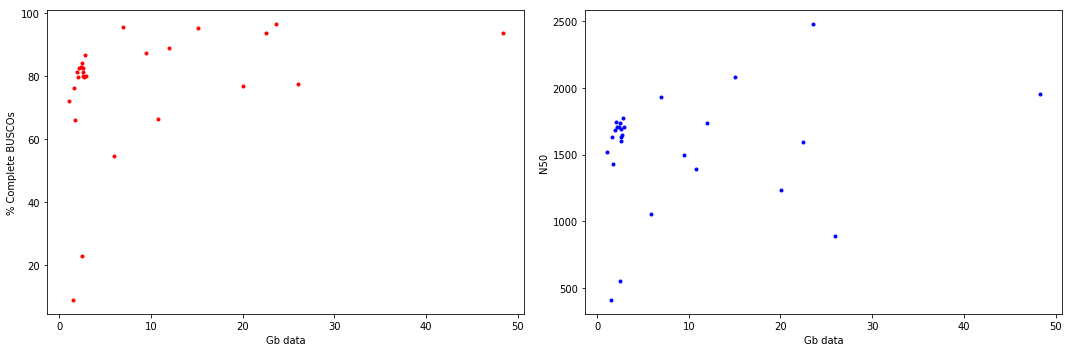

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(s_lyc_datasets['Gb data'], s_lyc_datasets['Complete BUSCOs'], 'ro', markersize=3)
plt.xlabel("Gb data")
plt.ylabel("% Complete BUSCOs")
plt.subplot(1, 2, 2)
plt.plot(s_lyc_datasets['Gb data'], s_lyc_datasets['N50'], 'bo', markersize=3)
plt.xlabel("Gb data")
plt.ylabel("N50")
plt.tight_layout()
plt.show()

#### Plot N50 vs. % BUSCOs

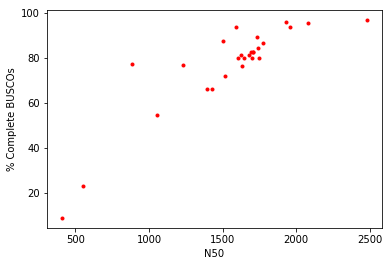

In [40]:
plt.plot(s_lyc_datasets['N50'], s_lyc_datasets['Complete BUSCOs'], 'ro', markersize=3)
plt.xlabel("N50")
plt.ylabel("% Complete BUSCOs")
plt.show()

#### Create combined result and evaluate
Collect all transcript assemblies by concatenating into one file, while including the data set name in the headers.
At this point, I decided to just concatenate all transcripts, but I might come back here in order to filter the transcripts in some way or merge redundant transcripts.

In [4]:
s_lyc_all_transcripts_concat = "%s/all_transcripts_concat.fasta" % analysis_dir

In [ ]:
# Concatenate all data sets
command = "for f in `find %s -name 'Trinity-combined.fasta'`; do dsName=`dirname $f | awk '{split($0,a,\"/\"); print a[9]}'`; sed \"s/>/>$dsName\_/\" $f >> %s; done"  %(analysis_dir, s_lyc_all_transcripts_concat)
send_commands_to_queue("concat_transcript_assemblies", [command], queue_conf)

In [25]:
# BUSCO on concat result
busco_command = "python %s/scripts/run_BUSCO.py --in %s --out all_transcripts_concat_BUSCO --lineage_path %s/embryophyta_odb9/ --mode transcriptome --cpu 10" \
% (busco_dir, s_lyc_all_transcripts_concat, busco_dir)
env_commands = ['export PATH="/share/apps/augustus/bin:$PATH"',
               'export PATH="/share/apps/augustus/scripts:$PATH"',
               'export AUGUSTUS_CONFIG_PATH="/groups/itay_mayrose/liorglic/software/busco/augustus_config"',
                'module load python/python-3.3.0',
               "cd %s" % analysis_dir]
busco_run_commands = env_commands + [busco_command]
send_commands_to_queue("all_transcripts_concat_BUSCO", busco_run_commands, queue_conf, n_cpu=10, block=False)

Job all_transcripts_concat_BUSCO (job id 6111419) sent to queue


('6111419', None)

In [5]:
# get assembly stats of concat result
commands = ["module load python/python-2.7.6", "python %s/get_genome_stats.py %s > %s.stats" %(PY_PATH, s_lyc_all_transcripts_concat, s_lyc_all_transcripts_concat)]
send_commands_to_queue("transcripts_concat_stats", commands, queue_conf)

Job transcripts_concat_stats (job id 6162161) completed successfully


('6162161', 0)

Get full length transcripts histogram

In [8]:
# Perform the blast search, reporting only the top alignment:
blast_res = "%s/all_transcripts_concat_vs_SP.blastx.outfmt6" % analysis_dir
blast_search_commands = ['module load blast/blast240',
                        'blastx -query %s -db %s -out %s -evalue 1e-20 -num_threads 20 -max_target_seqs 1 -outfmt 6'
                         %(s_lyc_all_transcripts_concat, realpath(sp_fasta), blast_res)]
# use utility script provided within Trinity to parse blast result
script_path = "/share/apps/Trinity-v2.6.6/util/analyze_blastPlus_topHit_coverage.pl"
parse_blast_res_commands = ["%s %s %s %s"
                            %(script_path, blast_res, s_lyc_all_transcripts_concat, realpath(sp_fasta))]

send_commands_to_queue("full_length_trans",blast_search_commands + parse_blast_res_commands,queue_conf, block=False, n_cpu=20)

Job full_length_trans (job id 6162162) sent to queue


('6162162', None)

In [16]:
all_concat_stats_path = s_lyc_all_transcripts_concat + '.stats'
all_concat_stats = pandas.read_csv(all_concat_stats_path, sep='\t', header=None, index_col=0)
all_concat_stats

,1
0,
Total length,"1,955,631,125"
Total scaffolds,"2,076,772"
# of gaps,"17,845,298"
% gaps,0
N50,"1,678"
L50,"354,165"
N90,350
L90,"1,326,334"
Min scaffold length,201
